# Face Detection using Haar Cascades

#### Goal

In this session,

• We will see the basics of face detection using Haar Feature-based Cascade Classifiers

• We will extend the same for eye detection etc.

#### Basics

Object Detection using Haar feature-based cascade classifiers is an effective object detection method proposed by
Paul Viola and Michael Jones in their paper, “Rapid Object Detection using a Boosted Cascade of Simple Features”. It is a **machine learning based approach** where a cascade function is trained from a lot of positive and negative
images. It is then used to detect objects in other images.

Here we will work with face detection. Initially, the algorithm needs a lot of positive images (images of faces) and
negative images (images without faces) to train the classifier. Then we need to extract features from it. For this, haar
features shown in below image are used. They are just like our convolutional kernel. Each feature is a single value
obtained by subtracting sum of pixels under white rectangle from sum of pixels under black rectangle.

![](haar1.png)

Now all possible sizes and locations of each kernel is used to calculate plenty of features. (Just imagine how much
computation it needs? Even a 24x24 window results over 160000 features). For each feature calculation, we need to
find sum of pixels under white and black rectangles. To solve this, they introduced the integral images. It simplifies
calculation of sum of pixels, how large may be the number of pixels, to an operation involving just four pixels. Nice,
isn’t it? It makes things super-fast.

But among all these features we calculated, most of them are irrelevant. For example, consider the image below. Top
row shows two good features. The first feature selected seems to focus on the property that the region of the eyes is
often darker than the region of the nose and cheeks. The second feature selected relies on the property that the eyes are darker than the bridge of the nose. But the same windows applying on cheeks or any other place is irrelevant. So
how do we select the best features out of 160000+ features? It is achieved by **Adaboost**.

![](haar2.png)

For this, we apply each and every feature on all the training images. For each feature, it finds the best threshold which
will classify the faces to positive and negative. But obviously, there will be errors or misclassifications. We select the
features with minimum error rate, which means they are the features that best classifies the face and non-face images.

Final classifier is a weighted sum of these weak classifiers. It is called weak because it alone can’t classify the image,
but together with others forms a strong classifier. The paper says even 200 features provide detection with 95%
accuracy. Their final setup had around 6000 features. (Imagine a reduction from 160000+ features to 6000 features.
That is a big gain).

In an image, most of the image region is non-face region. So it is a better idea to have a simple method to check if
a window is not a face region. If it is not, discard it in a single shot. Don’t process it again. Instead focus on region
where there can be a face. This way, we can find more time to check a possible face region.

For this they introduced the concept of **Cascade of Classifiers**. Instead of applying all the 6000 features on a window,
group the features into different stages of classifiers and apply one-by-one. If a window fails the first stage, discard it. We don’t consider remaining features on it.
If it passes, apply the second stage of features and continue the process. The window which passes all stages is a face
region.

So this is a simple intuitive explanation of how this face detection algorithm works

### Haar-cascade Detection in OpenCV

OpenCV comes with a trainer as well as detector. If you want to train your own classifier for any object like car, planes
etc. you can use OpenCV to create one.
Here we will deal with detection. 

OpenCV already contains many pre-trained classifiers for face, eyes, smile etc.
Those XML files are stored in opencv/data/haarcascades/ folder. Let’s create face and eye detector with
OpenCV.
First we need to load the required XML classifiers. Then load our input image (or video) in grayscale mode.

In [5]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
img = cv2.imread('friends.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

Now we find the faces in the image. If faces are found, it returns the positions of detected faces as Rect(x,y,w,h). Once
we get these locations, we can create a ROI for the face and apply eye detection on this ROI (since eyes are always on
the face).

(Text(0.5, 1.0, 'Output'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

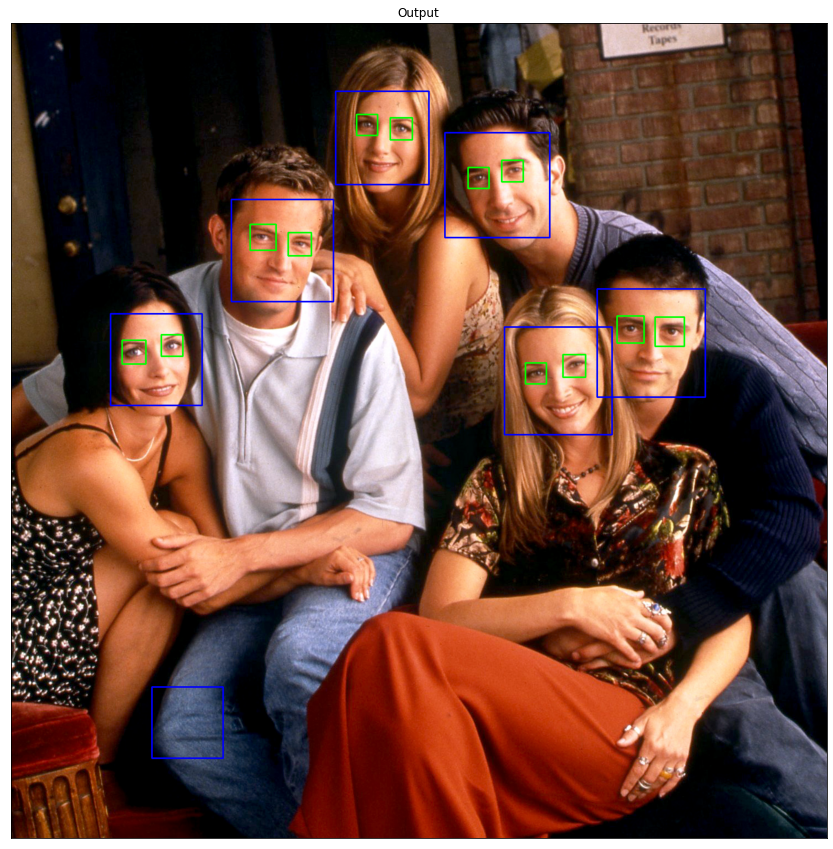

In [6]:
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize = (80,15))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Output'), plt.xticks([]), plt.yticks([])

# Cartoonizing images

#### Goal

In this session,

• We will use numerous operations that we have learnt to Cartoonize images.

Over the last few years professional cartoonizer software has popped up all over the place but is only rarely freeware. In order to achieve the basic cartoon effect, you don't need powerful rendering software or even years of experience. All you need is essentially a bilateral filter and some edge detection. The bilateral filter will reduce the color palette, which is essential for the cartoon look, and edge detection will allow you to produce bold silhouettes.

Using OpenCV and Python, an RGB color image can be converted into a cartoon in five steps:

    1.Apply a bilateral filter to reduce the color palette of the image.
    
    2.Convert the original color image to grayscale.
    
    3.Apply a median blur to reduce image noise in the grayscale image.
    
    4.Create an edge mask from the grayscale image using adaptive thresholding.
    
    5.Combine the color image from step 1 with the edge mask from step 4.


In [8]:
import cv2

num_down = 2       # number of downsampling steps
num_bilateral = 7  # number of bilateral filtering steps

img_rgb = cv2.imread("im.jpg")

# downsample image using Gaussian pyramid
img_color = img_rgb
for _ in range(num_down):
    img_color = cv2.pyrDown(img_color)

# repeatedly apply small bilateral filter instead of applying one large filter
for _ in range(num_bilateral):
    img_color = cv2.bilateralFilter(img_color, d=9,
                                    sigmaColor=9,
                                    sigmaSpace=7)

# upsample image to original size
for _ in range(num_down):
    img_color = cv2.pyrUp(img_color)
    
# convert to grayscale and apply median blur
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
img_blur = cv2.medianBlur(img_gray, 7)

# detect and enhance edges
def edge(block,const):
    return cv2.adaptiveThreshold(img_blur, 255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,blockSize=block,C=const)


#Vary thresholding parameters to obtain different outputs
img_edge1 = edge(5,1)
img_edge2 = edge(15,3)


# convert back to color, bit-AND with color image
img_edge1 = cv2.cvtColor(img_edge1, cv2.COLOR_GRAY2RGB)
img_cartoon1 = cv2.bitwise_and(img_color, img_edge1)

img_edge2 = cv2.cvtColor(img_edge2, cv2.COLOR_GRAY2RGB)
img_cartoon2 = cv2.bitwise_and(img_color, img_edge2)

# display
images=[img_rgb,img_cartoon1,img_cartoon2]

for i,img in enumerate(images):
    img=cv2.resize(img,(400,650))
    if i==0:
        cv2.imshow('Original',img)
        
    else:
        cv2.imshow(f'Cartoon{i}',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()